## 1. Importing Libraries

In [1]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

## 2. Setting Constants

In [10]:
# Constants
BASE_DIR = r"E:\NEW_FOLDER\Projects_Java_Python\Plant Disease Detection\archive\plantvillage dataset"
TARGET_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 10  # Increased to 10 for better accuracy

## 3. Getting Dataset Path

In [2]:
# Switch case-like function for directories
def get_dataset_path(mode):
    if mode == "color":
        return os.path.join(BASE_DIR, "color")
    elif mode == "greyscale":
        return os.path.join(BASE_DIR, "grayscale")
    elif mode == "segmented":
        return os.path.join(BASE_DIR, "segmented")
    else:
        raise ValueError("Invalid mode. Choose from 'color', 'greyscale', or 'segmented'.")

## 4. Splitting Dataset into Train and Test

In [3]:
# Splitting dataset into train/test
def split_dataset(dataset_path, output_path, test_size=0.3):
    classes = os.listdir(dataset_path)
    for cls in classes:
        cls_path = os.path.join(dataset_path, cls)
        images = os.listdir(cls_path)

        # Train-test split
        train_images, test_images = train_test_split(images, test_size=test_size, random_state=42)

        for img_set, folder in [(train_images, "train"), (test_images, "test")]:
            target_dir = os.path.join(output_path, folder, cls)
            os.makedirs(target_dir, exist_ok=True)
            for img in img_set:
                shutil.copy(os.path.join(cls_path, img), os.path.join(target_dir, img))

# 5. Building the Model

## i. CNN model

In [4]:
# Build a simplified model
def build_model(num_classes):
    model = models.Sequential([
        # First Convolutional Block
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Second Convolutional Block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Third Convolutional Block
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Flatten and Fully Connected Layers
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [5]:
# Train and evaluate the model
def train_and_evaluate(mode):
    dataset_path = get_dataset_path(mode)
    output_path = os.path.join(BASE_DIR, f"processed_{mode}")
    
    # Split dataset (if not already split)
    # split_dataset(dataset_path, output_path)

    # Directories for train and test
    train_dir = os.path.join(output_path, "train")
    test_dir = os.path.join(output_path, "test")

    # Data augmentation for training
    train_datagen = ImageDataGenerator(
        rescale=1.0 / 255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    # Rescaling for testing
    test_datagen = ImageDataGenerator(rescale=1.0 / 255)

    # Data generators
    train_gen = train_datagen.flow_from_directory(
        train_dir,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical'
    )

    test_gen = test_datagen.flow_from_directory(
        test_dir,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )

    # Build and train the model
    model = build_model(num_classes=len(train_gen.class_indices))
    history = model.fit(
        train_gen,
        epochs=EPOCHS,
        validation_data=test_gen
    )

    # Evaluate the model
    test_loss, test_acc = model.evaluate(test_gen)
    print(f"Mode: {mode} | Test Accuracy: {test_acc}")

    return history

In [6]:
# Plot training history
def plot_training_history(history, mode):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    
    plt.title(f'{mode} - Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title(f'{mode} - Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [7]:
# Main function
def main():
    modes = ['segmented', 'greyscale','color']
    for mode in modes:
        history = train_and_evaluate(mode)

        # Plot training history
        plot_training_history(history, mode)

Found 37998 images belonging to 38 classes.
Found 16308 images belonging to 38 classes.
Epoch 1/10
1188/1188 [==============================] - 1836s 2s/step - loss: 1.2607 - accuracy: 0.6367 - val_loss: 1.1598 - val_accuracy: 0.6699
Epoch 2/10
1188/1188 [==============================] - 1381s 1s/step - loss: 0.5429 - accuracy: 0.8256 - val_loss: 2.3719 - val_accuracy: 0.4763
Epoch 3/10
1188/1188 [==============================] - 1370s 1s/step - loss: 0.3850 - accuracy: 0.8774 - val_loss: 0.3685 - val_accuracy: 0.8869
Epoch 4/10
1188/1188 [==============================] - 1556s 1s/step - loss: 0.3105 - accuracy: 0.8986 - val_loss: 2.7016 - val_accuracy: 0.4871
Epoch 5/10
1188/1188 [==============================] - 1180s 993ms/step - loss: 0.2678 - accuracy: 0.9134 - val_loss: 0.6827 - val_accuracy: 0.7964
Epoch 6/10
1188/1188 [==============================] - 1665s 1s/step - loss: 0.2326 - accuracy: 0.9233 - val_loss: 1.2223 - val_accuracy: 0.7125
Epoch 7/10
1188/1188 [===========

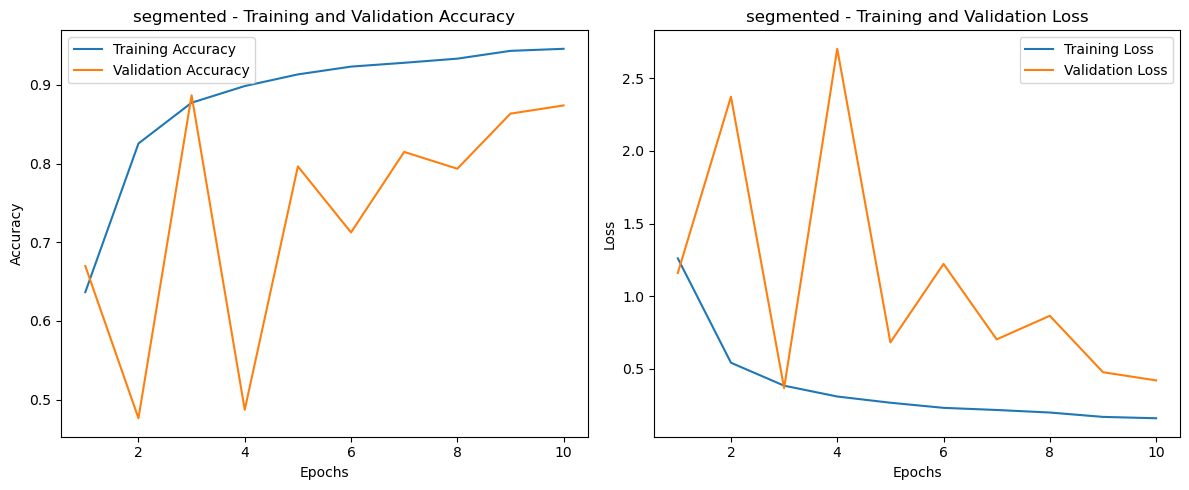

Found 37998 images belonging to 38 classes.
Found 16307 images belonging to 38 classes.
Epoch 1/10
1188/1188 [==============================] - 1561s 1s/step - loss: 1.5880 - accuracy: 0.5432 - val_loss: 1.2449 - val_accuracy: 0.6340
Epoch 2/10
1188/1188 [==============================] - 1150s 968ms/step - loss: 0.8737 - accuracy: 0.7284 - val_loss: 23.6225 - val_accuracy: 0.2628
Epoch 3/10
1188/1188 [==============================] - 1446s 1s/step - loss: 0.6872 - accuracy: 0.7855 - val_loss: 1.2505 - val_accuracy: 0.6835
Epoch 4/10
1188/1188 [==============================] - 1461s 1s/step - loss: 0.6140 - accuracy: 0.8056 - val_loss: 2.9104 - val_accuracy: 0.5350
Epoch 5/10
1188/1188 [==============================] - 1466s 1s/step - loss: 0.5328 - accuracy: 0.8266 - val_loss: 5.8088 - val_accuracy: 0.4648
Epoch 6/10
1188/1188 [==============================] - 1474s 1s/step - loss: 0.4834 - accuracy: 0.8423 - val_loss: 1.5413 - val_accuracy: 0.7389
Epoch 7/10
1188/1188 [==========

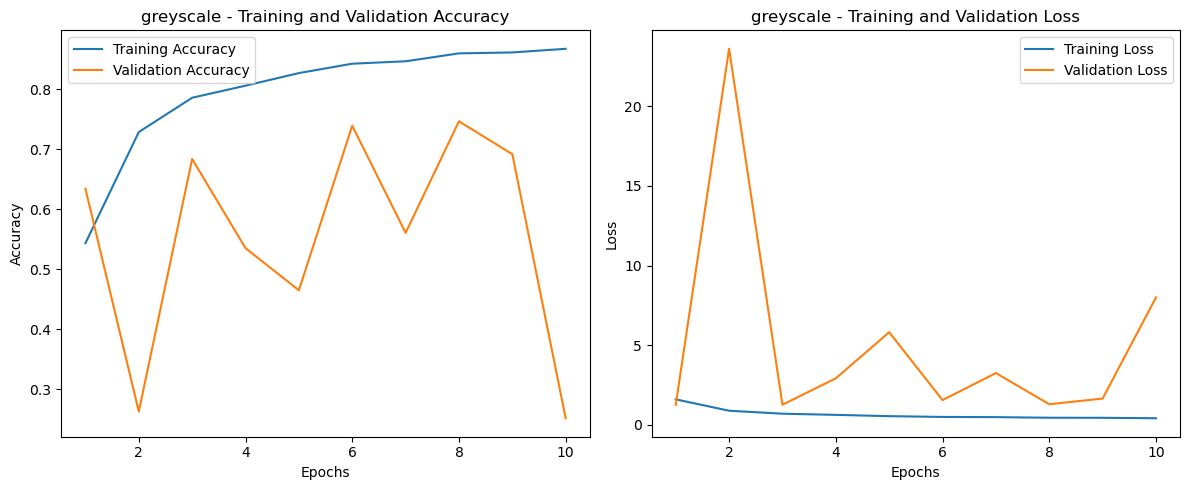

Found 37998 images belonging to 38 classes.
Found 16307 images belonging to 38 classes.
Epoch 1/10
1188/1188 [==============================] - 2016s 2s/step - loss: 0.9771 - accuracy: 0.7105 - val_loss: 2.0939 - val_accuracy: 0.5956
Epoch 2/10
1188/1188 [==============================] - 1482s 1s/step - loss: 0.4467 - accuracy: 0.8566 - val_loss: 1.0914 - val_accuracy: 0.7496
Epoch 3/10
1188/1188 [==============================] - 1225s 1s/step - loss: 0.2975 - accuracy: 0.9025 - val_loss: 1.0935 - val_accuracy: 0.7191
Epoch 4/10
1188/1188 [==============================] - 1295s 1s/step - loss: 0.2310 - accuracy: 0.9232 - val_loss: 0.3599 - val_accuracy: 0.8882
Epoch 5/10
1188/1188 [==============================] - 1183s 995ms/step - loss: 0.1971 - accuracy: 0.9358 - val_loss: 1.2332 - val_accuracy: 0.7838
Epoch 6/10
1188/1188 [==============================] - 1271s 1s/step - loss: 0.1697 - accuracy: 0.9435 - val_loss: 0.9162 - val_accuracy: 0.7998
Epoch 7/10
1188/1188 [===========

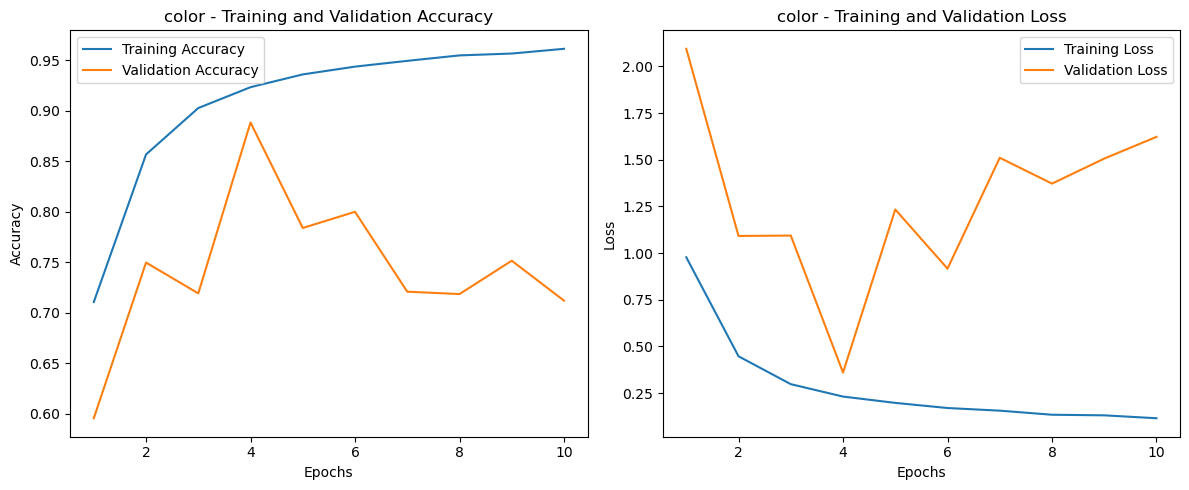

In [8]:
# Execute the main function
if __name__ == "__main__":
    main()